In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# upload dfs

In [3]:
c_df = pd.read_csv("/Users/jmadu1/Downloads/180601_Customer_Info.csv")
c_df

,customer_id,sign_up_date,sign_up_channel
0,2543,2021-04-26,Price Comparison Website
1,2181,2021-07-24,Referral
2,2399,2020-10-11,Bulb Website
3,674,2021-04-04,Referral
4,2332,2021-09-05,Price Comparison Website
...,...,...,...
1694,820,2021-07-17,Referral
1695,1945,2020-12-20,Price Comparison Website
1696,2132,2021-11-29,Bulb Website
1697,2228,2021-10-11,Referral


In [4]:
r_df = pd.read_csv("/Users/jmadu1/Downloads/180601_Referrals_Info.csv")
r_df

,referral_date,referrer_customer_id,sign_up_customer_id
0,2021-07-18,795,1771
1,2021-04-12,577,1510
2,2021-07-07,868,1858
3,2021-10-25,801,1778
4,2021-08-15,690,1637
...,...,...,...
995,2021-07-17,812,1789
996,2021-12-15,156,1031
997,2021-07-20,601,1537
998,2021-07-11,440,1350


# inspect data

## Data types

In [5]:
c_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_id      1699 non-null   int64 
 1   sign_up_date     1699 non-null   object
 2   sign_up_channel  1699 non-null   object
dtypes: int64(1), object(2)
memory usage: 39.9+ KB


In [6]:
c_df['sign_up_date'] = pd.to_datetime(c_df['sign_up_date'])

In [7]:
c_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customer_id      1699 non-null   int64         
 1   sign_up_date     1699 non-null   datetime64[ns]
 2   sign_up_channel  1699 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 39.9+ KB


In [8]:
r_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   referral_date         1000 non-null   object
 1   referrer_customer_id  1000 non-null   int64 
 2   sign_up_customer_id   1000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.6+ KB


In [9]:
r_df['referral_date'] = pd.to_datetime(r_df['referral_date'])

In [10]:
r_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   referral_date         1000 non-null   datetime64[ns]
 1   referrer_customer_id  1000 non-null   int64         
 2   sign_up_customer_id   1000 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 23.6 KB


## pandas profiling (nulls, correlation, basic statistical info)

In [11]:
import pandas_profiling
c_df.profile_report()

/var/folders/y2/m4k5jspd3091p82l071_qqbh0000gp/T/ipykernel_81332/2570576605.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
import pandas_profiling
r_df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## shape and other EDAs

date for x-axis, id for y-axis

### shape

In [13]:
print(f'referrals_df shape: {r_df.shape}')
print(f'customers_df shape: {c_df.shape}')

referrals_df shape: (1000, 3)
customers_df shape: (1699, 3)


In [14]:
print(f'customers_df duplicated values: {c_df.duplicated().sum()}')
print(f'referrals_df duplicated values: {r_df.duplicated().sum()}')

customers_df duplicated values: 0
referrals_df duplicated values: 0


### EDAs

date for x-axis, id for y-axis

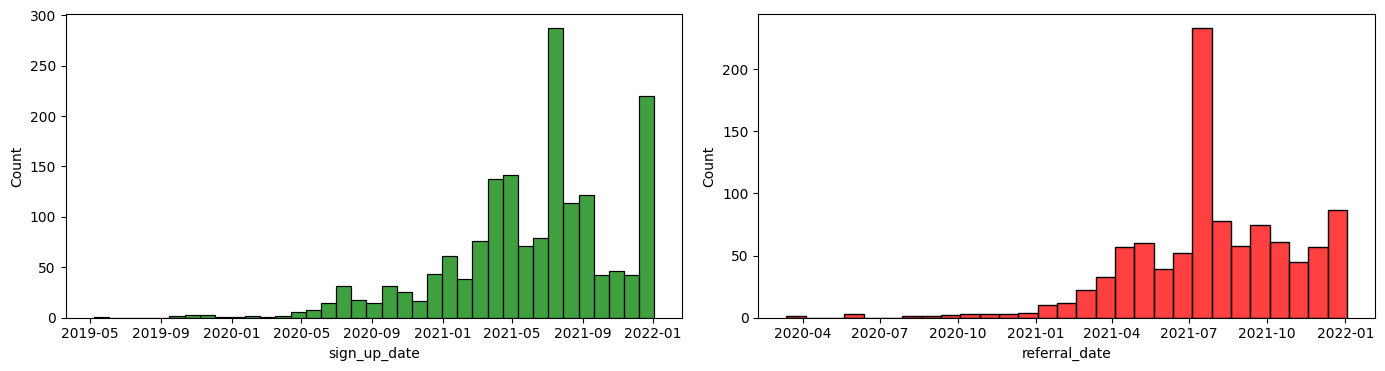

In [15]:
plt.figure(figsize=(14,7)) 

plt.subplot(2,2,1) 
sns.histplot(c_df['sign_up_date'], color='g')

plt.subplot(2,2,2) 
sns.histplot(r_df['referral_date'], color='r')

plt.tight_layout() 
plt.show()

### rethinking approach, re-organising data

1. When do members refer?
(Try to think about each member lifetime, starting from when they sign-up to Bulb.
The number of Bulb members is growing very quickly. A lot of Bulb members have not been with
Bulb for very long. Think about how this might affect your conclusions.)

what i want to do is append the dataframes such that i can compare the dates per customer id for when they signed up and when they referred, and take the difference in days and maybe create an average from that

so, i could combine the dataframes, clear all null values (as not every customer that joins the scheme refers, as indicated by the shape of each set of data) and somehow align the duplicates so i can derive the difference in dates and create a new column for that

In [16]:
c_df = c_df.sort_values(by=['customer_id'])
c_df

,customer_id,sign_up_date,sign_up_channel
1024,0,2020-06-20,Price Comparison Website
375,1,2021-10-25,Bulb Website
678,2,2021-04-04,Referral
666,3,2021-08-03,Price Comparison Website
1462,4,2020-08-20,Price Comparison Website
...,...,...,...
1071,2849,2020-09-26,Bulb Website
1675,2850,2021-07-20,Referral
1621,2851,2021-12-26,Price Comparison Website
1448,2852,2020-07-15,Bulb Website


In [17]:
r_df = r_df.sort_values(by=['referrer_customer_id'])
r_df

,referral_date,referrer_customer_id,sign_up_customer_id
484,2021-05-29,0,869
323,2021-12-23,1,870
246,2021-04-10,2,871
10,2021-12-30,3,872
76,2021-08-16,4,873
...,...,...,...
761,2021-11-06,864,1854
679,2021-10-01,865,1855
517,2021-05-03,866,1856
357,2021-05-15,867,1857


In [18]:
r_df.columns = ['referral_date', 'customer_id', 'sign_up_customer_id']

In [19]:
r_df

,referral_date,customer_id,sign_up_customer_id
484,2021-05-29,0,869
323,2021-12-23,1,870
246,2021-04-10,2,871
10,2021-12-30,3,872
76,2021-08-16,4,873
...,...,...,...
761,2021-11-06,864,1854
679,2021-10-01,865,1855
517,2021-05-03,866,1856
357,2021-05-15,867,1857


In [20]:
merged_df = pd.merge(c_df, r_df, on="customer_id", how="inner")
merged_df

,customer_id,sign_up_date,sign_up_channel,referral_date,sign_up_customer_id
0,0,2020-06-20,Price Comparison Website,2021-05-29,869
1,1,2021-10-25,Bulb Website,2021-12-23,870
2,2,2021-04-04,Referral,2021-04-10,871
3,3,2021-08-03,Price Comparison Website,2021-12-30,872
4,4,2020-08-20,Price Comparison Website,2021-08-16,873
...,...,...,...,...,...
827,863,2021-12-15,Price Comparison Website,2022-01-01,1853
828,864,2021-09-19,Referral,2021-11-06,1854
829,865,2020-09-13,Price Comparison Website,2021-10-01,1855
830,867,2020-12-27,Bulb Website,2021-05-15,1857


### more pandas profiling

In [21]:
merged_df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### EDA for merged df

In [22]:
merged_df

,customer_id,sign_up_date,sign_up_channel,referral_date,sign_up_customer_id
0,0,2020-06-20,Price Comparison Website,2021-05-29,869
1,1,2021-10-25,Bulb Website,2021-12-23,870
2,2,2021-04-04,Referral,2021-04-10,871
3,3,2021-08-03,Price Comparison Website,2021-12-30,872
4,4,2020-08-20,Price Comparison Website,2021-08-16,873
...,...,...,...,...,...
827,863,2021-12-15,Price Comparison Website,2022-01-01,1853
828,864,2021-09-19,Referral,2021-11-06,1854
829,865,2020-09-13,Price Comparison Website,2021-10-01,1855
830,867,2020-12-27,Bulb Website,2021-05-15,1857


In [23]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 832 entries, 0 to 831
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          832 non-null    int64         
 1   sign_up_date         832 non-null    datetime64[ns]
 2   sign_up_channel      832 non-null    object        
 3   referral_date        832 non-null    datetime64[ns]
 4   sign_up_customer_id  832 non-null    int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 71.3+ KB


In [24]:
merged_df['time_elapsed'] = merged_df['referral_date'] - merged_df['sign_up_date']
merged_df

,customer_id,sign_up_date,sign_up_channel,referral_date,sign_up_customer_id,time_elapsed
0,0,2020-06-20,Price Comparison Website,2021-05-29,869,343 days
1,1,2021-10-25,Bulb Website,2021-12-23,870,59 days
2,2,2021-04-04,Referral,2021-04-10,871,6 days
3,3,2021-08-03,Price Comparison Website,2021-12-30,872,149 days
4,4,2020-08-20,Price Comparison Website,2021-08-16,873,361 days
...,...,...,...,...,...,...
827,863,2021-12-15,Price Comparison Website,2022-01-01,1853,17 days
828,864,2021-09-19,Referral,2021-11-06,1854,48 days
829,865,2020-09-13,Price Comparison Website,2021-10-01,1855,383 days
830,867,2020-12-27,Bulb Website,2021-05-15,1857,139 days


In [26]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 832 entries, 0 to 831
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   customer_id          832 non-null    int64          
 1   sign_up_date         832 non-null    datetime64[ns] 
 2   sign_up_channel      832 non-null    object         
 3   referral_date        832 non-null    datetime64[ns] 
 4   sign_up_customer_id  832 non-null    int64          
 5   time_elapsed         832 non-null    timedelta64[ns]
dtypes: datetime64[ns](2), int64(2), object(1), timedelta64[ns](1)
memory usage: 77.8+ KB


In [32]:
merged_df['time_elapsed'] = merged_df['time_elapsed'].dt.days.astype('int64')

AttributeError: Can only use .dt accessor with datetimelike values

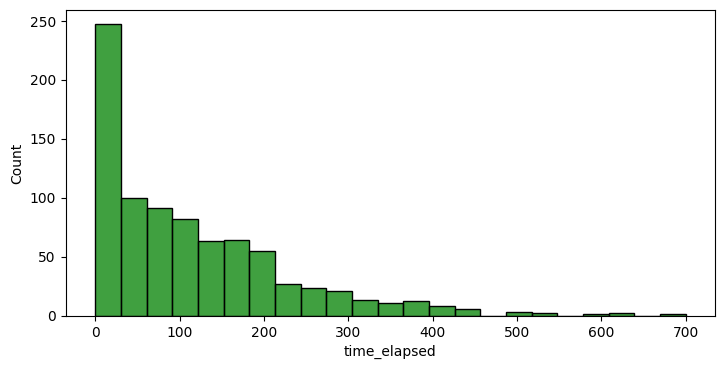

In [33]:
plt.figure(figsize=(14,7)) 

plt.subplot(2,2,1)
sns.histplot(merged_df['time_elapsed'], color='g')
#sns.scatterplot(data=merged_df, x=merged_df['sign_up_date'], y=merged_df['time_elapsed'])

plt.tight_layout() 
plt.show()

1. When do members refer?
(Try to think about each member lifetime, starting from when they sign-up to Bulb.
The number of Bulb members is growing very quickly. A lot of Bulb members have not been with
Bulb for very long. Think about how this might affect your conclusions.)

\n

members originally referred anywhere between 10 months and 2 years, as shown on the scatterplot. as time has passed the gap between joining the scheme and referring others shrank, to the point where some customers refer someone the same month they join.

2. Does the channel members are acquired from significantly impact how they refer? Do
you think we need a larger sample size to be sure?

\n

no; based on results in the 4th scatterplot (which has 